# Week 4 Advanced Arima modeling
## Time Series Analysis
### Earnest Salgado
### ID 12285784

In [1]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from sktime.forecasting.all import ForecastingHorizon
from sktime.forecasting.all import ExponentialSmoothing
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')

/Users/earnestsalgado/opt/anaconda3/lib/python3.9/site-packages/sktime/utils/validation/_dependencies.py:64: UserWarning: No module named 'prophet'. 'prophet' is a soft dependency and not included in the sktime installation. Please run: `pip install prophet` to install the prophet package. To install all soft dependencies, run: `pip install sktime[all_extras]`
  warnings.warn(msg)


## 1. 10 pts - Exploratory Data Analysis

### 1.A 10 pts Complete a quantitative and qualitative data exploration. Include a verbal summary of your EDA.

In [2]:
df = pd.read_csv('hw4_data.csv', parse_dates = ['ds'])

In [3]:
df

,ds,co2
0,1958-03-15,315.700
1,1958-04-15,317.450
2,1958-05-15,317.510
3,1958-06-15,316.685
4,1958-07-15,315.860
...,...,...
730,2019-01-15,410.920
731,2019-02-15,411.660
732,2019-03-15,412.000
733,2019-04-15,413.510


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
co2,735.0,354.210673,27.922811,313.2,328.785,351.34,376.515,414.83


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      735 non-null    datetime64[ns]
 1   co2     735 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 11.6 KB


In [6]:
df.isnull().sum()

ds     0
co2    0
dtype: int64

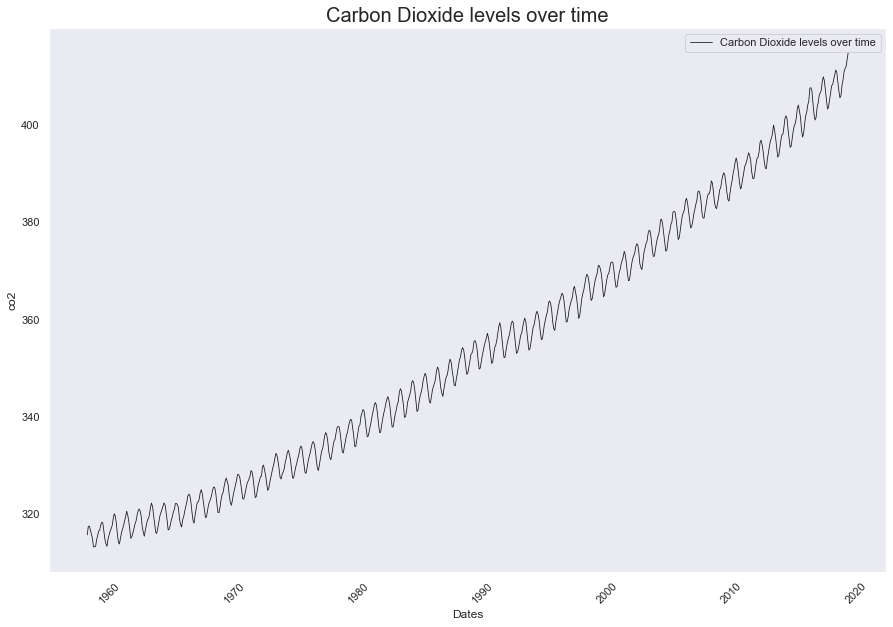

In [7]:
x = df['ds']

y = df['co2']

plt.figure(figsize=(15,10))  
plt.plot(x,y, color = 'k',label = "Carbon Dioxide levels over time", ls = '-', lw = 0.8)
#plt.plot(x, z, color = 'g',label = "SPY Price over time", ls = '-', lw = 0.8)

plt.xticks(rotation = 45)
plt.xlabel('Dates')
plt.ylabel('co2')
plt.title('Carbon Dioxide levels over time', fontsize = 20)
plt.grid()
plt.legend()
plt.show()

In [8]:
# correlation table with all the numeric features
df.corr()

,co2
co2,1.0


<AxesSubplot:>

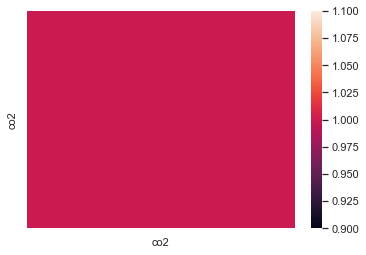

In [9]:
# heatmap based on the correlation table from above
sns.heatmap(df.corr())

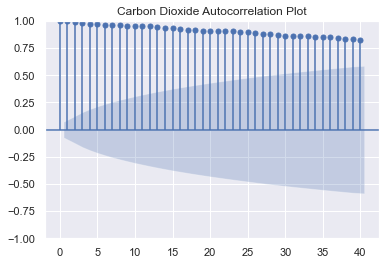

In [10]:
p = plot_acf(df['co2'], lags=40, title='Carbon Dioxide Autocorrelation Plot')

## 2. 30 pts – Seasonal ARIMA – need to use statsmodels in order to examine residuals
### 2.A - 6 pts Determine the seasonal differencing order, use y_train. Include the following: plot of differenced data, ADF results, kpss results

In [11]:
from statsmodels.tsa.statespace import sarimax
from statsmodels.tools.eval_measures import aicc
from sktime.transformations.series import boxcox
from sktime.forecasting.arima import ARIMA

<AxesSubplot:xlabel='ds'>

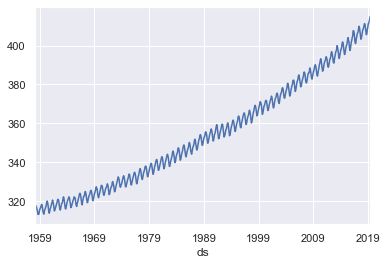

In [12]:
# selecting variable of intest & build uniform univariate time series
ts = df.groupby(pd.PeriodIndex(df['ds'], freq="M"))['co2'].mean()
ts.plot()

In [13]:
ts

ds
1958-03    315.700
1958-04    317.450
1958-05    317.510
1958-06    316.685
1958-07    315.860
            ...   
2019-01    410.920
2019-02    411.660
2019-03    412.000
2019-04    413.510
2019-05    414.830
Freq: M, Name: co2, Length: 735, dtype: float64

In [14]:
# set date as index
#df.set_index('ds', inplace = True)

In [15]:
# take a log transformation
bctransformer = boxcox.BoxCoxTransformer()
ts_transf = bctransformer.fit_transform(ts)

### Split into Train/test ( )

In [16]:
from sktime.forecasting.all import temporal_train_test_split
y_train, y_test = temporal_train_test_split(ts_transf)

In [17]:
y_train.index.min(), y_train.index.max()

(Period('1958-03', 'M'), Period('2004-01', 'M'))

In [18]:
y_test.index.min(), y_test.index.max()

(Period('2004-02', 'M'), Period('2019-05', 'M'))

In [19]:
print(y_train.shape)
print(y_test.shape)

(551,)
(184,)


### Examine Stationarity

In [20]:
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from copy import deepcopy

def adf_test(timeseries):
    print ('Dickey-Fuller Test Result:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#define KPSS
def kpss_test(timeseries, trend='c'):
    print ('KPSS Test Result:')
    kpsstest = kpss(timeseries, regression=trend)
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [21]:
adf_test(y_train)

Dickey-Fuller Test Result:
Test Statistic                   1.321806
p-value                          0.996728
#Lags Used                      13.000000
Number of Observations Used    537.000000
Critical Value (1%)             -3.442586
Critical Value (5%)             -2.866937
Critical Value (10%)            -2.569645
dtype: float64


In [22]:
adf_co2 = adfuller(y_train)
ad_fuller_pval = adf_co2[1]

if ad_fuller_pval <= 0.05:
    print('stationarity from ad_fuller test: TRUE')
else:
    print('stationarity from ad_fuller test: FALSE')

stationarity from ad_fuller test: FALSE


In [23]:
kpss_test(y_train)

KPSS Test Result:
Test Statistic            3.552593
p-value                   0.010000
Lags Used                15.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [24]:
kpss_co2 = kpss(y_train)
kpss_pval = kpss_co2[1]

if kpss_pval >= 0.05:
    print('stationarity from kpss_fuller test: TRUE')
else:
    print('stationarity from kpss_fuller test: FALSE')

stationarity from kpss_fuller test: FALSE


### No stationarity yet... Difference the data and examine again

In [25]:
y_train_seasdiff = y_train.diff(12).dropna()

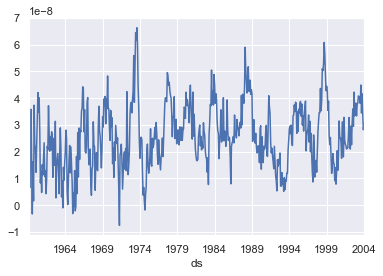

In [26]:
y_train_seasdiff.plot()
plt.show()

In [27]:
adf_test(y_train_seasdiff)

Dickey-Fuller Test Result:
Test Statistic                  -5.087568
p-value                          0.000015
#Lags Used                      13.000000
Number of Observations Used    525.000000
Critical Value (1%)             -3.442867
Critical Value (5%)             -2.867061
Critical Value (10%)            -2.569710
dtype: float64


In [28]:
adf_co2 = adfuller(y_train_seasdiff)
ad_fuller_pval = adf_co2[1]

if ad_fuller_pval <= 0.05:
    print('stationarity from ad_fuller test: TRUE')
else:
    print('stationarity from ad_fuller test: FALSE')

stationarity from ad_fuller test: TRUE


In [29]:
kpss_test(y_train_seasdiff)

KPSS Test Result:
Test Statistic            0.456659
p-value                   0.052733
Lags Used                14.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [30]:
kpss_co2 = kpss(y_train_seasdiff)
kpss_pval = kpss_co2[1]

if kpss_pval >= 0.05:
    print('stationarity from kpss_fuller test: TRUE')
else:
    print('stationarity from kpss_fuller test: FALSE')

stationarity from kpss_fuller test: TRUE


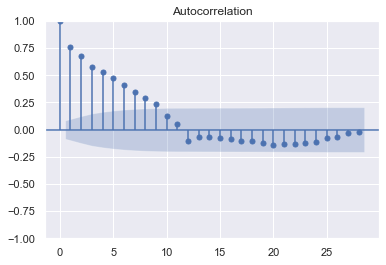

In [31]:
plot_acf(y_train_seasdiff)
plt.show()

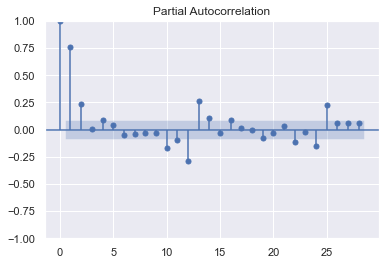

In [32]:
plot_pacf(y_train_seasdiff)
plt.show()

### 2.B - 6 pts Determine the non-seasonal differencing order, use the seasonally differenced training time series. Include the following: plot of differenced data, ADF results, kpss results, ACF and PACF

### Examine ACF and PACF plots

In [33]:
#y_train_nonseasdiff = np.diff(y_train_seasdiff)
y_train_nonseasdiff = y_train_seasdiff.diff(12).dropna()

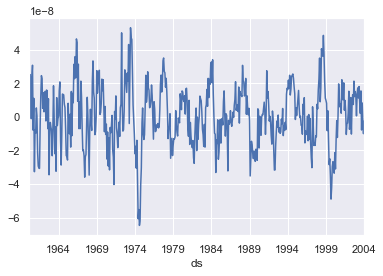

In [34]:
y_train_nonseasdiff.plot()
plt.show()

In [35]:
adf_test(y_train_nonseasdiff)

Dickey-Fuller Test Result:
Test Statistic                -6.193103e+00
p-value                        6.055567e-08
#Lags Used                     1.500000e+01
Number of Observations Used    5.110000e+02
Critical Value (1%)           -3.443212e+00
Critical Value (5%)           -2.867213e+00
Critical Value (10%)          -2.569791e+00
dtype: float64


In [36]:
adf_gdp = adfuller(y_train_nonseasdiff)
ad_fuller_pval = adf_gdp[1]

if ad_fuller_pval <= 0.05:
    print('stationarity from ad_fuller test: TRUE')
else:
    print('stationarity from ad_fuller test: FALSE')

stationarity from ad_fuller test: TRUE


In [37]:
kpss_test(y_train_nonseasdiff)

KPSS Test Result:
Test Statistic            0.01462
p-value                   0.10000
Lags Used                13.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
dtype: float64


In [38]:
kpss_gdp = kpss(y_train_nonseasdiff)
kpss_pval = kpss_gdp[1]

if kpss_pval >= 0.05:
    print('stationarity from kpss_fuller test: TRUE')
else:
    print('stationarity from kpss_fuller test: FALSE')

stationarity from kpss_fuller test: TRUE


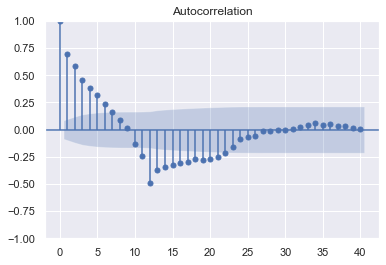

In [39]:
plot_acf(y_train_nonseasdiff, lags = 40)
plt.show()

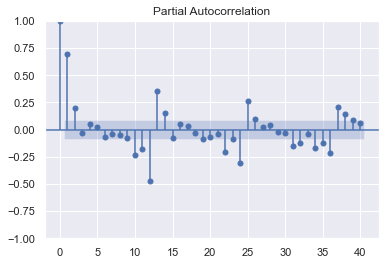

In [40]:
plot_pacf(y_train_nonseasdiff, lags = 40)
plt.show()

### 2.C - 6 pts Fit and predict a SARIMA model using your best estimate of the SARIMA(p,d,q)(P,D,Q)m order. Return the model summary

In [41]:
sarima_model = sm.tsa.statespace.SARIMAX(endog=y_train,order=(3,0,1), seasonal_order=(0, 2, 0, 12))
sarima_fit = sarima_model.fit()
print(sarima_fit.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.67639D-01    |proj g|=  1.08047D+04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      3     23      1     0     0   1.516D+04  -8.154D+00
  F =  -8.1538114284023422     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  551
Model:    

### 2.D - 6 pts Examine the residuals. Include the following: plot, histogram, ACF, Ljung Box results

In [42]:
# Return AICc
print("AICc for order " + str(sarima_model.order) + str(sarima_model.seasonal_order) +": " +str(sarima_fit.aicc))

AICc for order (3, 0, 1)(0, 2, 0, 12): -8975.385030951587


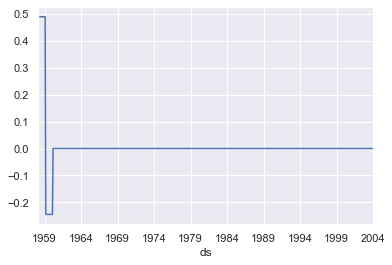

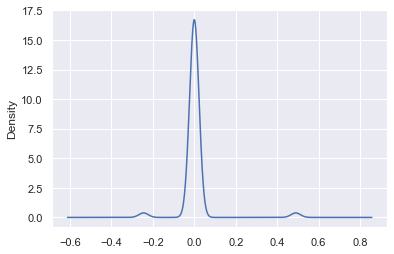

count    5.510000e+02
mean     5.331064e-03
std      8.067344e-02
min     -2.447847e-01
25%     -8.568507e-09
50%      9.701123e-11
75%      8.244287e-09
max      4.895694e-01
dtype: float64


In [43]:
# residual checks
# line plot of residuals
residuals = sarima_fit.resid
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [44]:
residuals

ds
1958-03    4.895693e-01
1958-04    4.895694e-01
1958-05    4.895694e-01
1958-06    4.895694e-01
1958-07    4.895693e-01
               ...     
2003-09   -1.624108e-08
2003-10    8.984920e-09
2003-11   -4.973802e-09
2003-12   -1.056862e-08
2004-01    3.478337e-09
Freq: M, Length: 551, dtype: float64

In [45]:
resid = residuals[24:]
resid

ds
1960-03   -7.022079e-10
1960-04    2.564527e-08
1960-05    9.493013e-09
1960-06   -1.915904e-08
1960-07    1.961440e-08
               ...     
2003-09   -1.624108e-08
2003-10    8.984920e-09
2003-11   -4.973802e-09
2003-12   -1.056862e-08
2004-01    3.478337e-09
Freq: M, Length: 527, dtype: float64

<AxesSubplot:xlabel='ds'>

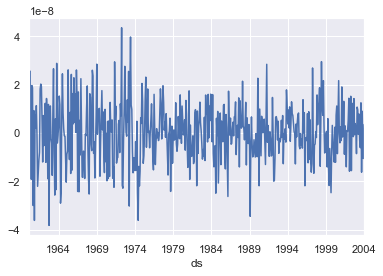

In [46]:
resid.plot()

<AxesSubplot:>

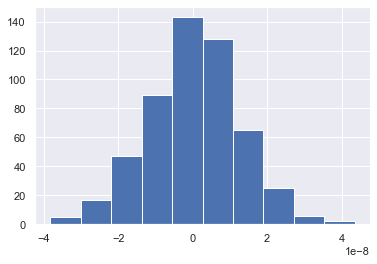

In [47]:
resid.hist()

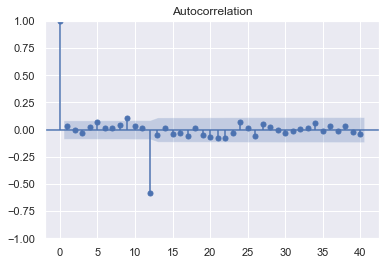

In [48]:
plot_acf(resid, lags = 40)
plt.show()

In [49]:
sm.stats.acorr_ljungbox(resid, lags=[10], return_df=True, boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
10,11.809813,0.297987,11.605567,0.312321


### 2.E - 6 pts 6 pts Predict the test set. Include the following: MAE, MSE, MAPE, sMAPE, MASE. Can use prebuilt functions or calculate by hand.

In [50]:
y_pred=sarima_fit.forecast(steps = len(y_test))

<AxesSubplot:xlabel='ds'>

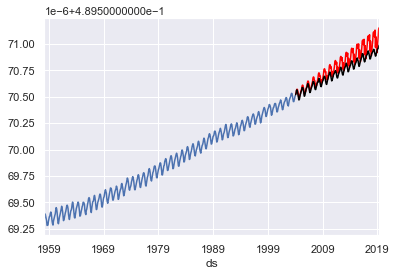

In [51]:
# plot
y_train.plot()
y_pred.plot(color='red')
y_test.plot(color = 'black')

In [52]:
def plot_results(y_train, y_test, y_pred):
    # plot the results
    y_train.plot()
    y_test.plot()

    y_pred.plot()

    plt.legend(['y_train','y_test','y_pred'])
    plt.show()

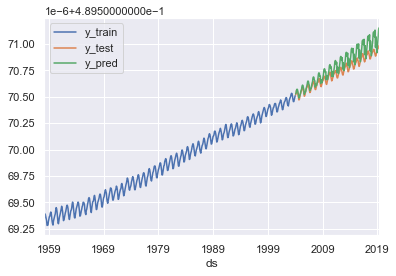

In [53]:
# model prediction
plot_results(y_train, y_test, y_pred)

In [60]:
def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

In [61]:
#calculate SMAPE
smape(y_test, y_pred)

1.3462270162156626e-05

In [56]:
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError
mase = MeanAbsoluteScaledError()
mase(y_test, y_pred, y_train=y_train)

3.0905916524235106

In [57]:
from sktime.performance_metrics.forecasting import MeanAbsoluteError
mae = MeanAbsoluteError()
mae(y_test, y_pred)

6.59073497037035e-08

In [58]:
from sktime.performance_metrics.forecasting import MeanSquaredError
mse = MeanSquaredError()
mse(y_test, y_pred)

6.987969025173637e-15

In [59]:
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
mape = MeanAbsolutePercentageError(symmetric=False)
mape(y_test, y_pred)

1.3462271618784467e-07

In [ ]:
sarima_fit.summary()

## 3. 30 pts – Auto ARIMA – need to use pmdarima in order to examine residuals
### 3.A - 6 pts Fit using auto_arima(), you may need to provide the differencing orders.

### 3.B - 6 pts Return the model summary

### 3.C - 6 pts Examine the residuals. Include the following: plot, histogram, ACF, Ljung Box results

### 3.D - 6 pts Predict the test set. Include the following: MAE, MSE, MAPE, sMAPE, MASE. Can use prebuilt functions or calculate by hand.

### 3.E - 6 pts Summarize the difference between your SARIMA and the Auto Arima models. Compare order, performance on training data, performance on test data. Which model would you go forward with?

## 4. 30 pts plus 20 pts extra credit – Recursive method with best model
### 4.A - A. 10 pts Use/modify the rolling fit class to fit and predict with the best model from above. Adjust train size from the sample in RollingFit_for_Assignment4.ipynb. This probably works best w sktime implementation.

### 4.B - *20 pts extra credit* Create your own function or class to perform a different method of recursive forecasting. Can use any other recursive method, here is a paper for inspiration, not limitation: https://arxiv.org/pdf/1108.3259.pdf

### 4.C - 10 pts Include the following: MAE, MSE, MAPE, sMAPE, MASE. Can use prebuilt functions or calculate by hand.

### 4.D - 10 pts Summarize the difference between your Recursive forecasts and your h-step ahead forecasts from SARIMA and Auto ARIMA. Explain the methodologies and the reason that you get different results. What are the advantages and disadvantages of the recursive method.